In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Cleaning the Data

In [2]:
additional_stopwords = ["i'm", "i'll", "us", "yo", "uh", "oh", "ooh", "oooh", "re", "di", "we re",
                           "man", "hey", "la", "nas", "can", "yeah", "can","see", "n't", "'s","'m", 
                            "'re","'", "na", "gon", "'ll", 'get', 'got', 'ta', "ai", "ca"]
stop_words = set(stopwords.words('english')).union(additional_stopwords)

In [3]:
df = pd.read_csv('/Volumes/SANDISK/Music/all_albums.csv')

Delete album titled 'The Album' as it was incorrectly downloaded by scraper

In [4]:
df = df.drop(df[df['album'] == 'The Album' ].index)

In [5]:
df['album'].unique()

array(['Illmatic', 'It Was Written', 'I Am...', 'Nastradamus',
       'Stillmatic', 'The Lost Tapes', 'God’s Son', 'Street’s Disciple',
       'Hip Hop Is Dead', 'Nas (Untitled)', 'Distant Relatives',
       'Life Is Good', 'NASIR', 'King’s Disease', 'King’s Disease II',
       'Magic'], dtype=object)

In [6]:
def clean_lyrics_format(lyrics):
    """
    Cleans the text of the lyrics column
    """
    
    remove_exception = "'"
    lyrics = re.sub('^[^\n]*\n', '', lyrics)  # Removes the first line up until the new line char that is not lyric
    lyrics = re.sub('[0-9]{1,}Embed', '', lyrics) # Removes the last line few words that is not part of lyric
    lyrics = re.sub('\[.*?\]', '', lyrics) #Removes all character between brackets
    lyrics = re.sub(r"[^\w"+remove_exception+"]", ' ', lyrics) #removes all non-alpha characters except (')
    lyrics = re.sub(' +', ' ', lyrics).lower().strip() #removes whitespaces and lowercases text
    
    return str(lyrics)
    
    

In [7]:
def stop_n_word(lyrics):
    
    #lemmatizer = WordNetLemmatizer()
    
    lyrics = word_tokenize(lyrics)
    lyrics = [word for word in lyrics if word not in stop_words]
    lyrics = " ".join(['n-word' if word in ['nigga', 'niggas', 'nigger', 'niggers'] else word for word in lyrics])
    #normalized = " ".join([lemmatizer.lemmatize(word) for word in lyrics])

    return lyrics

In [8]:
df['lyrics_cleaned'] = df['lyrics'].apply(clean_lyrics_format)

In [9]:
df['lyrics_cleaned'][0]

"street's disciple my raps are trifle i shoot slugs from my brain just like a rifle stampede the stage i leave the microphone split play mr tuffy while i'm on some pretty tone shit verbal assassin my architect pleases when i was 12 i went to and you're sitting at home doing this shit i should be earning a medal for this stop fuckin' around and be a man there ain't nothin' out here for you oh yes there is this yo nas yo what the fuck is this bullshit on the radio son chill chill that's the shit god chill ayo yo pull down the shade man let's count this money nigga ayo nas put the jacksons and the grants over there you know what i'm sayin' cause we spendin' the jacksons you know how we get down baby true true nas yo nas man shit is mad real right now in the projects for a nigga yo word to mother all them crab ass rappers be comin' up to me man word to mother man i think we need to let them niggas know it's real man true indeed knamsayin' but when it's real you doin' this even without a re

# Visualizing the word count of each album

<AxesSubplot:title={'center':'Word Count per Album'}, ylabel='album'>

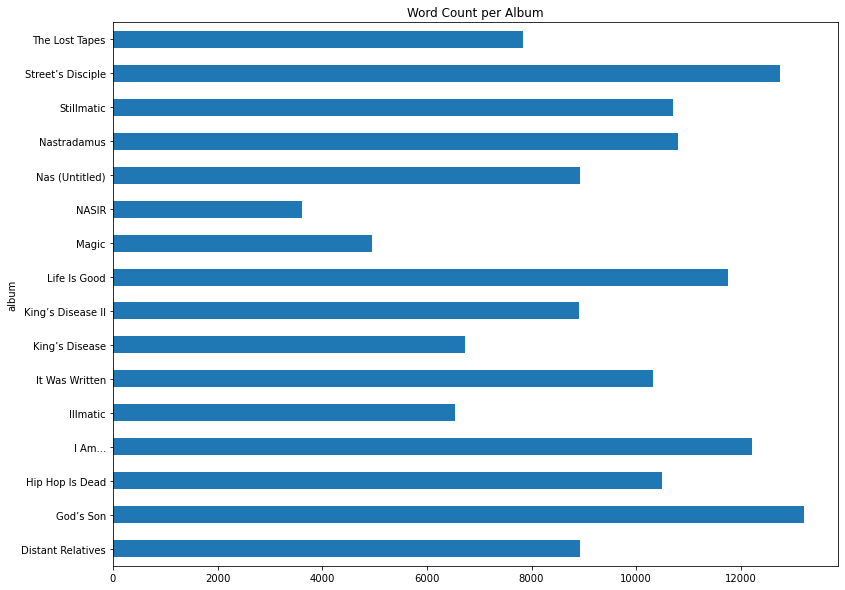

In [10]:
df['lyric_word_count'] = df['lyrics_cleaned'].apply(lambda x: len(str(x).split(' ')))
df['lyric_word_count'].groupby(df['album']).sum().plot.barh(title='Word Count per Album', figsize=(13,10))

Now that the count of words for each album is complete, time to remove stop words from the cleaned lyrics

In [11]:
#Removing stop words from the cleaned lyrics 
df['lyrics'] = df['lyrics_cleaned'].apply(stop_n_word)

In [12]:
df['lyrics'][0]

"street disciple raps trifle shoot slugs brain like rifle stampede stage leave microphone split play mr tuffy pretty tone shit verbal assassin architect pleases 12 went sitting home shit earning medal stop fuckin around nothin yes fuck bullshit radio son chill chill shit god chill ayo pull shade let count money n-word ayo put jacksons grants know sayin cause spendin jacksons know baby true true shit mad real right projects n-word word mother crab ass rappers comin word mother think need let n-word know real true indeed knamsayin real doin even without record contract knamsayin question since back sayin regardless go keep real tryin many mansions coupes kid doubt keep real true true ayo grand wizard mayo takin n-word long time phillies take hennessy ayo dunn c'mon c'mon stop wavin stop pointin dunn take clip n-word alright take hennessy sayin take clip c'mon take light phillies n-word stop fuckin burnin phillies light phillies pass henrock pass henrock n-word act like know drinkin strai

# Visualizing the 20 most used Nas words

Text(0, 0.5, 'Count')

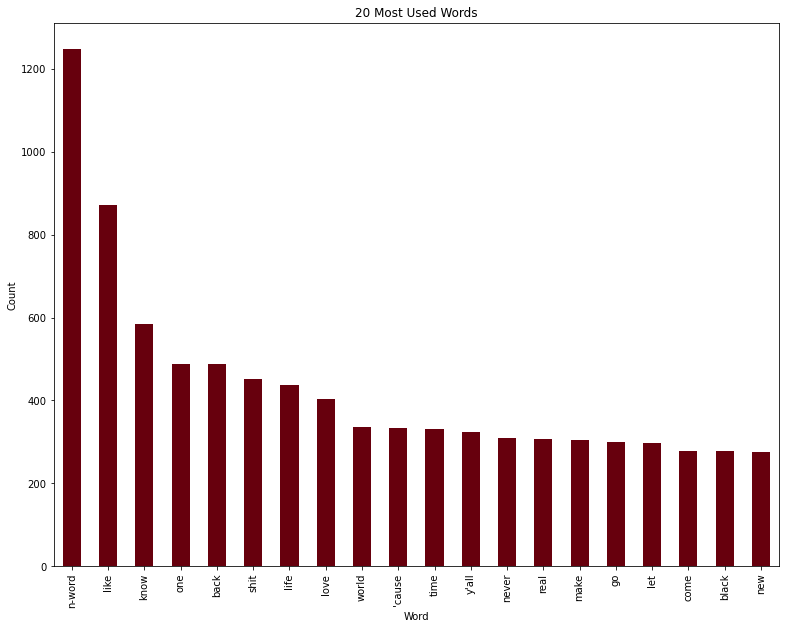

In [13]:
ax = pd.Series(" ".join(df['lyrics']).split()).value_counts() \
[:20].plot(kind='bar', title='20 Most Used Words' ,figsize=(13,10), colormap='Reds_r')                                                                  
ax.set_xlabel("Word")
ax.set_ylabel("Count")

# Visualizing findings with Word Cloud

To create a Word Cloud we need to join all the lyrics into one long string

In [14]:
all_lyrics = " ".join(word for word in df['lyrics'])

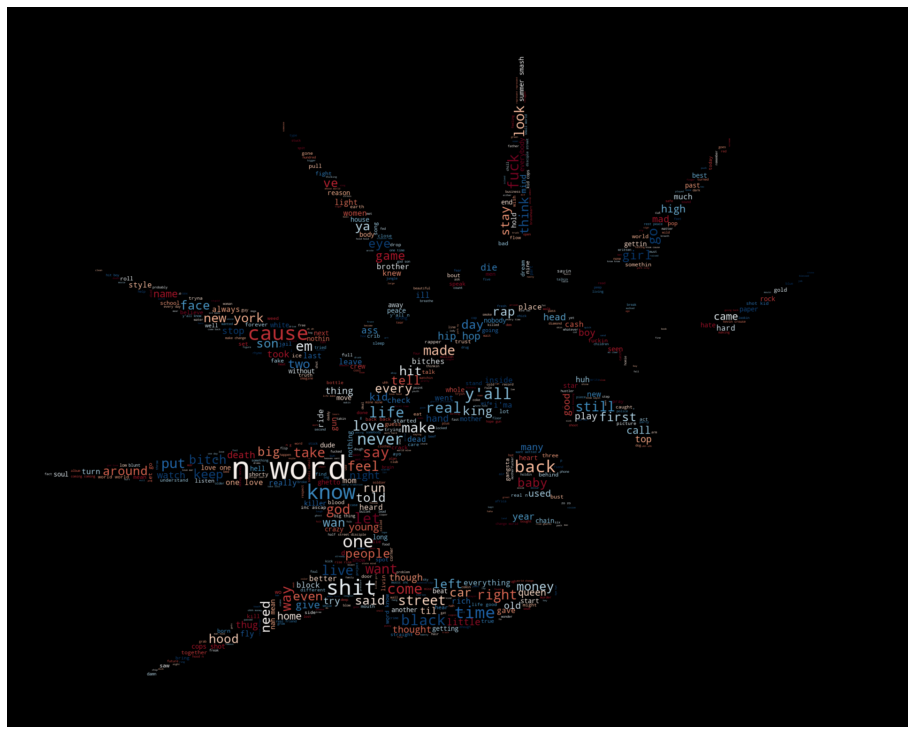

In [15]:
#Read in the image
icon = Image.open('/Volumes/SANDISK/Music/statue-of-liberty-logo.jpg')
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon)

#Convert the image into a Numpy array so it could be used with WordCloud
rgb_array = np.array(image_mask)

#WordCloud configuration
wordcloud = WordCloud(width = 2000, height = 2000, background_color='black', mask=rgb_array,
                      min_font_size = 5, colormap='RdBu', max_words=5000).generate(all_lyrics)
plt.figure(figsize = (13,10), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Term Frequency Inverse Document Frequency (TFIDF)

* TFIDF is a numerical statistic used to indicate how important each word is to a document in a collection of documents
* It consists of two components, term frequency and the inverse document frequency
    1. Term frequency is the measure of how often a word appears in a document
    2. Inverse Document frequency is the measure of how often a word appears across all corpus documents. More frequently appearing words are penalized as they give less insight into document meaning
* TFIDF is calculated as the term frequency multiplied by the inverse document frequency

# Non-Negative Matrix Factorization (NMF)

* NMF is an algorithm that can be used to get a grouping of co-occuring words. Then using these list of words and our knowledge of Nas' music we can create topics that the words represent.
* We will set the NMF model n_components parameter to 6 to create 6 different topics
* For each topic we will also use the argsort to get the index positions of the 20 words with the highest scores so we could get use 'get_features_names_out()' at that index position 

For the parameters the 'max_df' is set to .95 which tells the model to not include words that appear in more than 95% of the lyrics. The ‘min_df’ is set to 2 which will tell the model to ignore words that appear in less than 2 of the song lyrics.

In [16]:
#Initialize the TfidVectorizer with arguments noted above. ngram_range is set to generate 1-2 word results
tfidf = TfidfVectorizer(max_df = .95, min_df = 2, ngram_range=(1,2))

In [19]:
#Returns the tfidf scores for each term-document pair 
dtm = tfidf.fit_transform(df['lyrics'])

In [20]:
len(tfidf.get_feature_names_out())

8535

In [18]:
#n_components set to 6 to generate 6 topics. Will then fit the nmf model to the results of the 
#lyrics column tfidf scores. random_state set to 42 to generate same results for multiple tests
nmf_model = NMF(n_components=6, random_state = 42)
nmf_model.fit(dtm)

NMF(n_components=6, random_state=42)

The tfidf model generated over 8000 feature names

# The 6 topics created with their top 20 words

In [21]:
for index, topic in enumerate(nmf_model.components_):
    print(f"THE TOP 20 WORDS FOR TOPIC # {index}")
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-20:]])
    print('\n')

THE TOP 20 WORDS FOR TOPIC # 0
['never', 'em', 'son', 'coming', 'know', 'life', 'cause', 'kill', 'want', 'make', 'uhh', 'money', 'bitch', 'like', 'all', 'fuck', 'back', 'real', 'shit', 'word']


THE TOP 20 WORDS FOR TOPIC # 1
['things', 'come', 'matter', 'let', 'would', 'still', 'think', 'never', 'good', 'stop', 'hate', 'people', 'king', 'go', 'cause', 'love', 'every', 'life', 'know', 'like']


THE TOP 20 WORDS FOR TOPIC # 2
['stomped', 'dead', 'love', 'live', 'pray', 'stay', 'roll', 'every', 'give hip', 'ladies', 'thugs love', 'thugs', 'give', 'wreck', 'dj', 'station', 'every station', 'hop', 'hip hop', 'hip']


THE TOP 20 WORDS FOR TOPIC # 3
['new world', 'mind', 'inc', 'rappers', 'greatest', 'word', 'back', 'mind new', 'state', 'york new', 'carry', 'cross', 'city new', 'state mind', 'york state', 'york city', 'city', 'new york', 'york', 'new']


THE TOP 20 WORDS FOR TOPIC # 4
['world mine', 'sent', 'mine whose', 'make change', 'small', 'whose', 'although', 'heaven', 'seems', 'whose 

In [22]:
#Transform the tfidf scores
topic_results = nmf_model.transform(dtm)

Create a new column with each topic generated corresponding to its lyric

In [23]:
df['Topic'] = topic_results.argmax(axis=1)

From the list of topic words above, we can use our knowledge of Nas' music to create a topic dictionary with their meanings and map this to the dataframe 'Topic' column. It should be noted that the words generated for the topics were not sufficient to create conclusive topics.

In [24]:
topic_dict = {0: "Life/Normal", 1: "Empowerment", 2:"Violence", 3: "NY/Best Rapper", 4:"Political/Change", 
               5: "Sentimental/Family"}
df['Topic Label'] = df['Topic'].map(topic_dict)

We can now examine how many songs on each album are from each topic. We will group the dataframe by the 'release_year' and 'album' columns to get a count of each topic. The index is sorted so we can see over time how the topic of Nas' album change

In [25]:
topic_grouped = df.groupby(['release_year', 'album'])['Topic Label'].value_counts().sort_index()

In [26]:
topic_grouped

release_year  album              Topic Label       
1994          Illmatic           Empowerment           2
                                 Life/Normal           4
                                 NY/Best Rapper        1
                                 Political/Change      2
                                 Sentimental/Family    1
                                                      ..
2021          King’s Disease II  Violence              1
              Magic              Empowerment           4
                                 Life/Normal           3
                                 NY/Best Rapper        1
                                 Violence              1
Name: Topic Label, Length: 65, dtype: int64

# Visualizing the findings

<AxesSubplot:xlabel='release_year,album'>

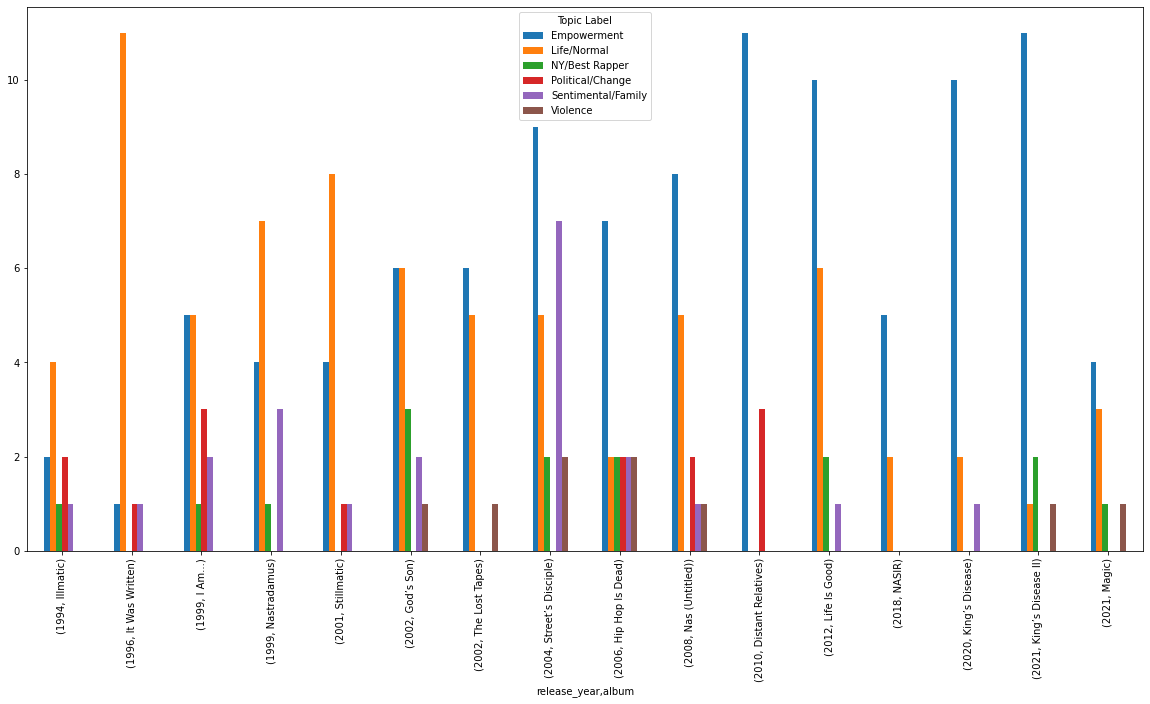

In [27]:
topic_grouped.unstack(2).plot.bar(figsize=(20,10))

From the graph above and the topics that were created, it is clear that over the years Nas' albums have increased with the amount of songs that have a topic of empowerment. This is most evident with his 2010 album Distant Relatives which is a collaborative album with reggae artist Damian Marley. Distant Relatives featured a heavy theme of African ancestry and unity.

# Word2vec


Word2vec is a statistical learning algorithm that develops word embeddings from a corpus of text.
We will be able to see how similar certain words are to each other when used by Nas.

Note the word2vec model takes a list of lists. Each inner list is a document in the corpus and each element in the inner lists is a word token

In [28]:
import gensim

In [29]:
words_for_model = [word_tokenize("".join([word for word in df['lyrics']]))]

In [34]:
words_for_model[0][:20]

['street',
 'disciple',
 'raps',
 'trifle',
 'shoot',
 'slugs',
 'brain',
 'like',
 'rifle',
 'stampede',
 'stage',
 'leave',
 'microphone',
 'split',
 'play',
 'mr',
 'tuffy',
 'pretty',
 'tone',
 'shit']

The lenght of all the joined and tokenized lyrics list is over 75,000 words

In [36]:
len(words_for_model[0])

77064

In [37]:
model = gensim.models.Word2Vec(words_for_model, vector_size=100,  window=5, min_count=65, sg=1, workers=4)

In [38]:
#Dictionary of words in the model and their index
vocab_list = model.wv.key_to_index.items()

In [39]:
vocab_list

dict_items([('n-word', 0), ('like', 1), ('know', 2), ('back', 3), ('one', 4), ('shit', 5), ('life', 6), ('love', 7), ('world', 8), ("'cause", 9), ('time', 10), ("y'all", 11), ('never', 12), ('make', 13), ('real', 14), ('go', 15), ('let', 16), ('come', 17), ('black', 18), ('could', 19), ('new', 20), ("'em", 21), ('every', 22), ('say', 23), ('money', 24), ('fuck', 25), ('want', 26), ('still', 27), ('take', 28), ('way', 29), ('god', 30), ('made', 31), ('wan', 32), ('right', 33), ('keep', 34), ('big', 35), ('put', 36), ('look', 37), ('hood', 38), ('think', 39), ('day', 40), ('would', 41), ('good', 42), ('hit', 43), ('bitch', 44), ('two', 45), ('tell', 46), ('live', 47), ('feel', 48), ('girl', 49), ('baby', 50), ('give', 51), ('need', 52), ('ya', 53), ('even', 54), ('first', 55), ('around', 56), ("'ve", 57), ('street', 58), ('change', 59), ('kid', 60), ('york', 61), ('stop', 62), ('said', 63), ('people', 64), ('g', 65), ('hold', 66), ('cause', 67), ('nah', 68), ('son', 69), ('music', 70), (

# Similar Words when used by Nas

We will now see the most similar words to the 5 most used words by Nas

In [40]:
top_five_words = pd.Series(" ".join(df['lyrics']).split()).value_counts()[:5].keys().tolist()

In [41]:
top_five_words

['n-word', 'like', 'know', 'one', 'back']

In [42]:
def get_similar_words(word, num_words):
    return model.wv.most_similar(word, topn=num_words)

In [45]:
#Cosine similarity between mean of the projection weight vectors of a word and other words in the model
for word in top_five_words:
    print(f"The most similiar words to '{word}' are: \n{get_similar_words(word, 5)}", '\n')    

The most similiar words to 'n-word' are: 
[('kid', 0.9374349117279053), ('fuck', 0.9290865063667297), ('shit', 0.918927013874054), ('bitches', 0.9175304770469666), ('always', 0.9049341082572937)] 

The most similiar words to 'like' are: 
[('eyes', 0.963759183883667), ('better', 0.9584237337112427), ('summer', 0.9571278095245361), ('took', 0.9562612175941467), ('death', 0.9547321200370789)] 

The most similiar words to 'know' are: 
[('always', 0.9352971315383911), ('next', 0.926980197429657), ('turn', 0.9224528670310974), ('bitches', 0.9093932509422302), ('best', 0.9028158187866211)] 

The most similiar words to 'one' are: 
[('need', 0.929064154624939), ('love', 0.9040530920028687), ('two', 0.8385447263717651), ('time', 0.8366459608078003), ('god', 0.7866207361221313)] 

The most similiar words to 'back' are: 
[('say', 0.8987598419189453), ('streets', 0.8972375392913818), ('going', 0.882014274597168), ('hold', 0.8794944286346436), ('run', 0.877758264541626)] 



# Visualizing Similar Words with t-Distributed Stochastic Neighbor Embedding (TSNE)

TSNE is a dimensionality reduction technique designed for visualizing higher dimensional data in a 2-D space.

To visualize the clustering of words we will use a slighlty modified function from Kaggle by Jeff Delaney found here: https://www.kaggle.com/code/jeffd23/visualizing-word-vectors-with-t-sne/notebook

In [46]:
from sklearn.manifold import TSNE

In [47]:
"""
FROM KAGGLE
"""

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.key_to_index.keys():
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(np.asarray(tokens))

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='left',
                     va='bottom')
    plt.show()

/Users/delanole/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/delanole/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


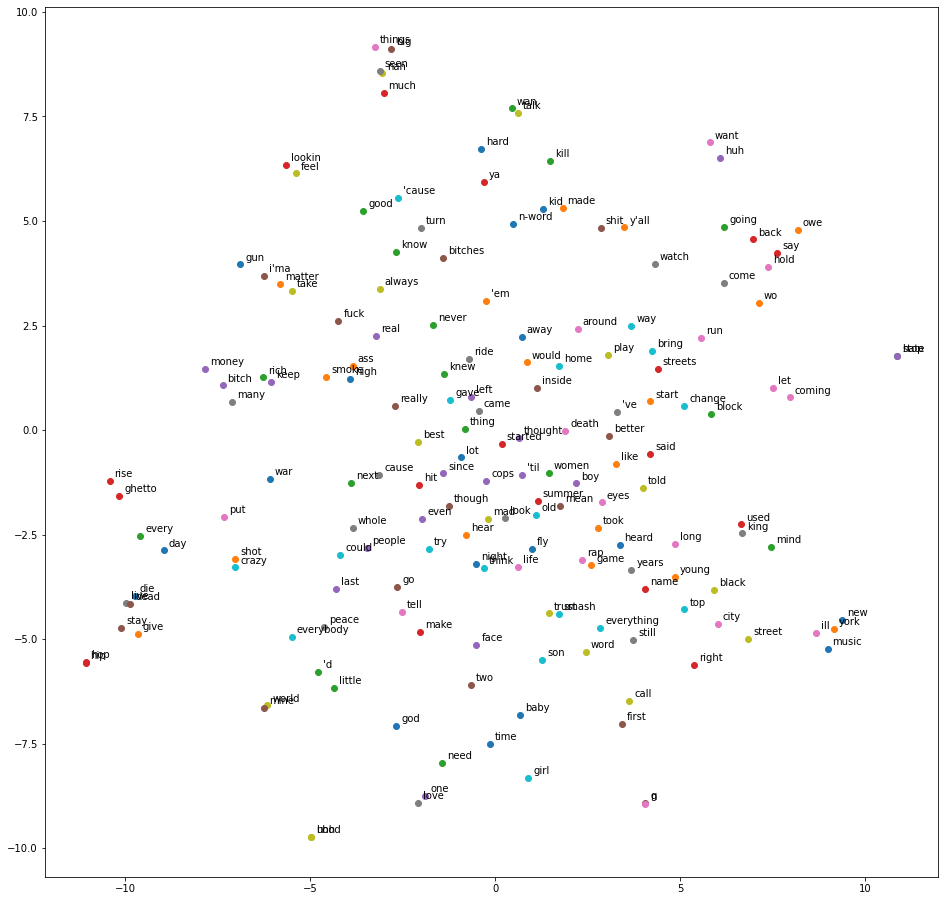

In [48]:
tsne_plot(model)

From the above graph there are certain clustering of words like:
* new and york
* one and love
* rise and ghetto
* world and mine
* peace and everybody

From our knowledge of Nas' music we know that there are several songs with these words used together like 'One Love', 'The World is Yours', 'N.Y. State of Mind' and 'Every Ghetto'

# Lyric Sentiment Analysis

We will use NLTK library called VADER to perform a sentiment Analysis of Nas' lyrics. Analyzing rap lyrics will be difficult as there are many slang words and often times a song may contain negative words but contain an overall positive message. Additionally VADER is trained on social media texts so the results are not expected to be ideal. VADER's polarity_scores() function returns a dictionary with values of negative, positive, neutral and compound scores respectively. We will use the compound score as it normalizes all the other scores and is the overall sentiment.

In [49]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/delanole/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [51]:
sid = SentimentIntensityAnalyzer()

In [52]:
df['lyrics_cleaned']

0      street's disciple my raps are trifle i shoot s...
1      yeah yeah ayo black it's time word word it's t...
2      ayo what's up what's up let's keep it real son...
3      it's yours whose world is this the world is yo...
4      right right check me out y'all nasty nas in yo...
                             ...                        
241    shout my young new york niggas out there on th...
242    yeah i don't work this hard to be around peopl...
243    hold up and analyze come on get on get some li...
244    can't bury you with your money can't bury you ...
245    back by popular demand it's magic ded ded dedi...
Name: lyrics_cleaned, Length: 235, dtype: object

In [53]:
df['lyric_sentiment'] = df['lyrics_cleaned'].apply(lambda x: "Negative" if sid.polarity_scores(x)['compound'] <= \
                                                0 else "Positive")

In [54]:
df.iloc[:9, :]

,track_number,track_name,album,release_year,lyrics,lyrics_cleaned,lyric_word_count,Topic,Topic Label,lyric_sentiment
0,1.0,The Genesis,Illmatic,1994,street disciple raps trifle shoot slugs brain ...,street's disciple my raps are trifle i shoot s...,381,0,Life/Normal,Negative
1,2.0,N.Y. State of Mind,Illmatic,1994,ayo black time word word time time aight begin...,yeah yeah ayo black it's time word word it's t...,836,3,NY/Best Rapper,Negative
2,3.0,Life’s a Bitch,Illmatic,1994,ayo let keep real son count money know sayin a...,ayo what's up what's up let's keep it real son...,595,1,Empowerment,Negative
3,4.0,The World Is Yours,Illmatic,1994,whose world world world mine mine mine whose w...,it's yours whose world is this the world is yo...,818,4,Political/Change,Negative
4,5.0,Halftime,Illmatic,1994,right right check y'all nasty area cause mass ...,right right check me out y'all nasty nas in yo...,697,0,Life/Normal,Negative
5,6.0,Memory Lane (Sittin’ in da Park),Illmatic,1994,aight fuck shit word word fuck shit y'know say...,aight fuck that shit word word fuck that other...,656,0,Life/Normal,Negative
6,7.0,One Love,Illmatic,1994,kid know shit rough doin bid cops came shoulda...,what up kid i know shit is rough doin' your bi...,952,4,Political/Change,Positive
7,8.0,One Time 4 Your Mind,Illmatic,1994,illmatic illmatic illmatic haha haha check one...,yeah it's illmatic yeah yeah it's illmatic yea...,576,5,Sentimental/Family,Positive
8,9.0,Represent,Illmatic,1994,represent represent represent represent repres...,represent represent represent represent repres...,679,0,Life/Normal,Negative


In [55]:
lyric_sen = df.groupby(['release_year','album'])['lyric_sentiment'].value_counts().sort_index()

# Visualizing Nas Lyric Sentiment by Album

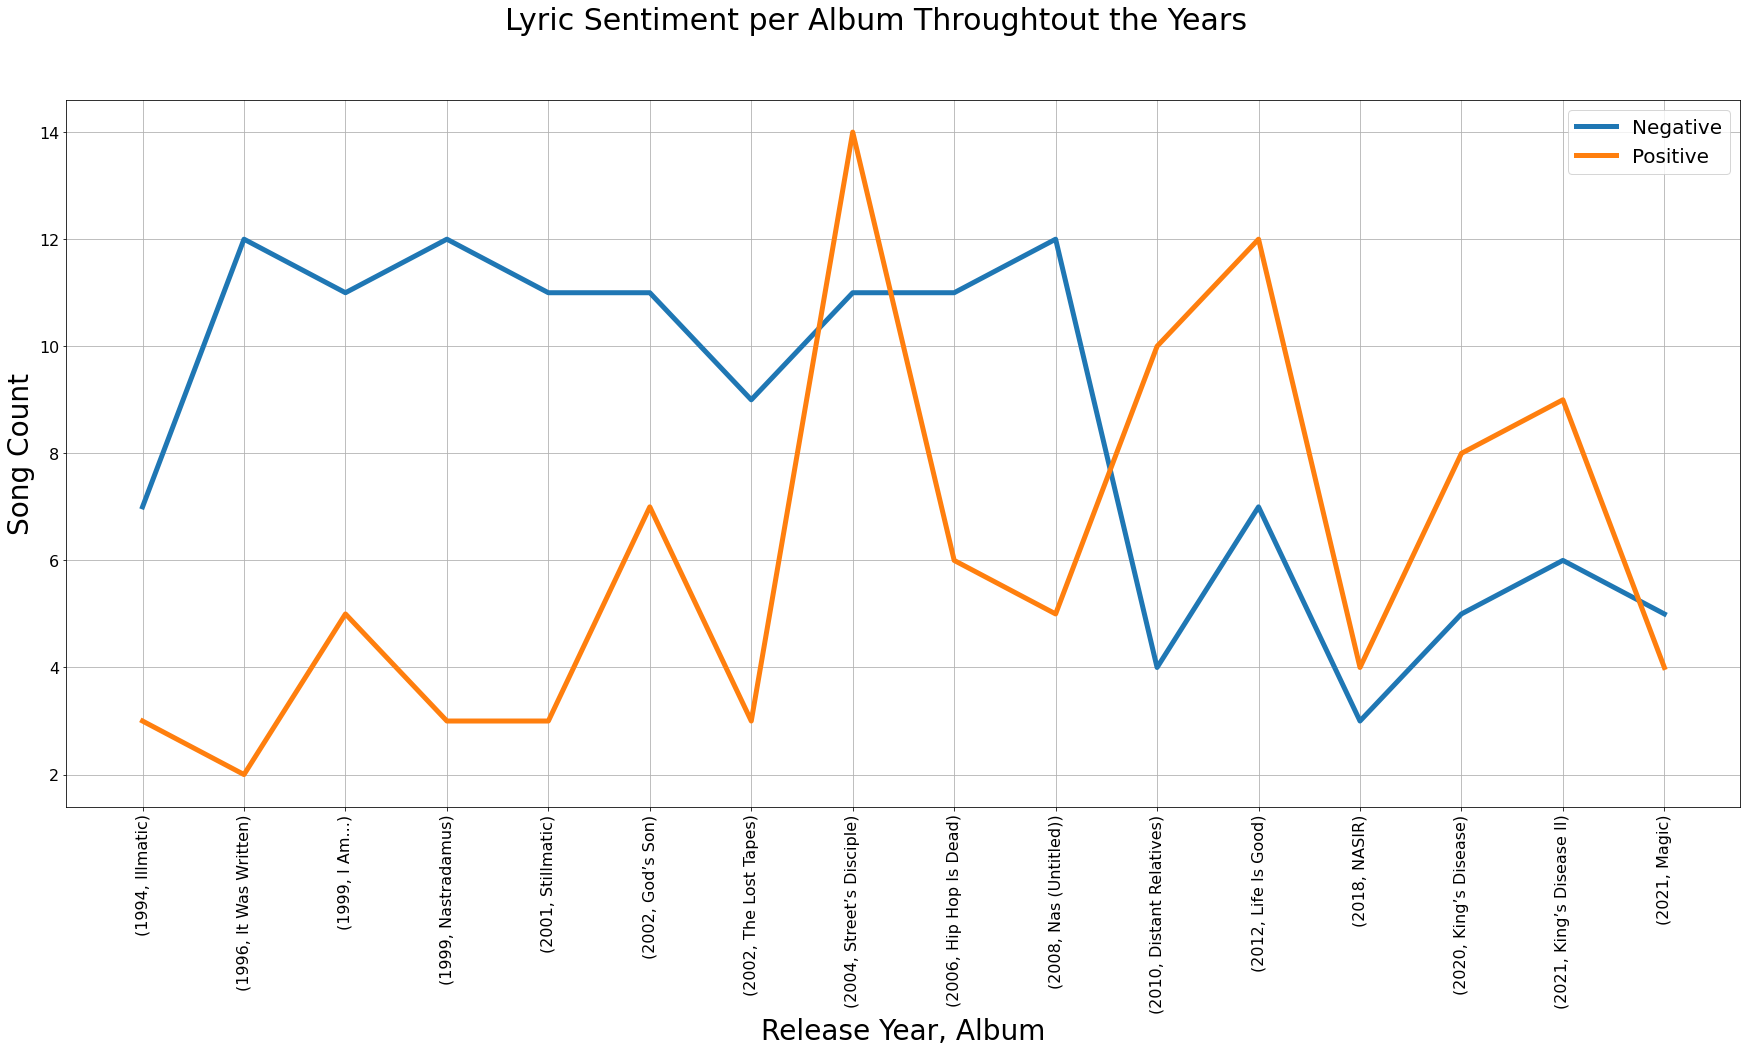

In [56]:
n = list(range(16))
fig, ax = plt.subplots(figsize=(30,13))
lyric_sen.unstack(2).plot(ax=ax, linewidth=5, xticks = n, rot=90, fontsize=16)
fig.suptitle('Lyric Sentiment per Album Throughtout the Years', fontsize=30)
plt.xlabel('Release Year, Album', fontsize=28)
plt.ylabel('Song Count', fontsize=28)
plt.legend(prop={'size': 20})
plt.grid()

While performing sentiment analysis on rap lyrics is not ideal, it is worth noting that Nas has made more positive songs as his career progressed. The model incorrectly labeled a few of his most positive songs as negative most notably  The World Is Yours. The model however, successfully label another of his most positive songs If I Ruled The World correctly as Positive. 